## CS5488 Project - Price Prediction on Cryptocurrencies
### Project Group 5
<!--
Poon Bing Chun
Jia Shuyue
Li Ka Faat
Tso Yiu Chuen
-->

#### Objective
In this project, we attempt to predict the exchange rates of cryptocurrencies using historical prices of other cryptocurrencies, by training a deep neural network distributedly across several machines.

Distributed training is a collection of techniques for using multiple processors located on different machines for training machine learning models. It is an increasingly important deep learning technique, since it enables the training of wider neural networks which is too cumbersome to manage on one machine only.

#### Plan
The Horovod library (paper) will be used and the training machines will be grouped by an Apache Spark cluster (which will be covered in the last few weeks of the lecture). Horovod distributes training batches to machines for training, averages the gradients of gradient descents, and aggregates the validation metrics returned by each machine. It supports common deep learning frameworks like Keras, TensorFlow and PyTorch.

We will compare the convergence rates with and without distributed training using Tensorboard.

In [2]:
import pandas as pd
from urllib.request import urlopen as u

#### Data Collection

We have written a Python script to collect historical cryptocurrency finance data from [https://coinmarketcap.com/](https://coinmarketcap.com/). The date range is 1st January, 2019 to 22nd September, 2021 (i.e. the day we collected the data). We have parsed the data into the machine-readable `pandas` `DataFrame` format and placed it in Google Drive.

In [8]:
from requests import Session

def download_from_google_drive(id):
    URL = "https://docs.google.com/uc?export=download"

    session = Session()

    response = session.get(URL, params = {'id': id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response):
    CHUNK_SIZE = 32768

    with open('historical_coin_data_5m.json', "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_from_google_drive('1gkXRtX1BfeC3uxYb6WxGTn2fN5U8S1OZ')

In [3]:
df = pd.read_json('historical_coin_data_5m.json')

In [10]:
df

,Currency,DateTime,Price USD,Trading Volume Last 24h,Market Cap,Price BTC,DunnoWhatThisIs
0,Litecoin,2019-01-01 08:04:00,31.133169,3.800241e+08,1.862125e+09,8.183427e-03,4.894641e+05
1,Bitcoin,2019-01-01 08:04:01,3804.417038,4.637869e+09,6.640638e+10,1.000000e+00,1.745508e+07
2,XRP,2019-01-01 08:04:01,0.360121,5.027181e+08,1.469083e+10,9.465870e-05,3.861520e+06
3,Dogecoin,2019-01-01 08:04:02,0.002367,1.779630e+07,2.784091e+08,6.221000e-07,7.318046e+04
4,Stellar,2019-01-01 08:04:04,0.114630,9.050305e+07,2.196406e+09,3.013080e-05,5.773304e+05
...,...,...,...,...,...,...,...
5124733,Internet Computer,2021-09-22 05:49:10,48.568079,3.332303e+08,7.911265e+09,1.121945e-03,1.827539e+05
5124734,Internet Computer,2021-09-22 05:49:12,48.568079,3.332303e+08,7.911265e+09,1.121945e-03,1.827539e+05
5124735,VeChain,2021-09-22 05:54:14,0.096595,5.599202e+08,6.212570e+09,2.231800e-06,1.435412e+05
5124736,VeChain,2021-09-22 05:54:16,0.096595,5.599202e+08,6.212570e+09,2.231800e-06,1.435412e+05


In [15]:
df.iloc[5124735]['Price USD']

0.09659510090000001

Let us analyse the time series by plotting the raw **Price USD** data (in log scale because the difference in price range of cryptocurrencies are quite large). A clear upward trend, cyclical variation, and some irregularities (sudden surge of price) can be observed. Seasonal variation does not seem to be present. As there is a trend, the time series is not stationary.

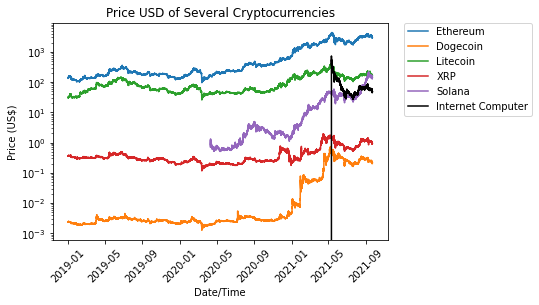

In [5]:
import matplotlib.pyplot as plt

index = 'Price USD'

eth = df[df['Currency']=='Ethereum']
plt.plot(eth['DateTime'], eth[index], label='Ethereum')

vec = df[df['Currency']=='Dogecoin']
plt.plot(vec['DateTime'], vec[index], label='Dogecoin')

btc = df[df['Currency']=='Litecoin']
plt.plot(btc['DateTime'], btc[index], label='Litecoin')

xrp = df[df['Currency']=='XRP']
plt.plot(xrp['DateTime'], xrp[index], label='XRP')

sol = df[df['Currency']=='Solana']
plt.plot(sol['DateTime'], sol[index], label='Solana')

ico = df[df['Currency']=='Internet Computer']
plt.plot(ico['DateTime'], ico[index], 'k-', label='Internet Computer')

plt.title(f'{index} of Several Cryptocurrencies')
plt.xlabel('Date/Time')
plt.ylabel('Price (US$)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

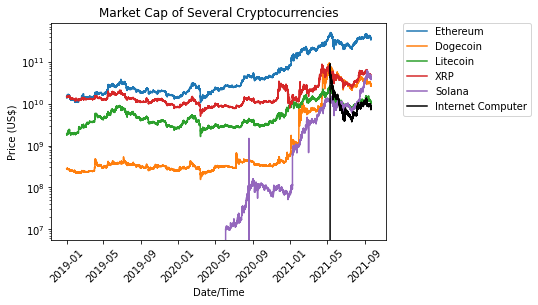

In [7]:
import matplotlib.pyplot as plt

index = 'Market Cap'

eth = df[df['Currency']=='Ethereum']
plt.plot(eth['DateTime'], eth[index], label='Ethereum')

vec = df[df['Currency']=='Dogecoin']
plt.plot(vec['DateTime'], vec[index], label='Dogecoin')

btc = df[df['Currency']=='Litecoin']
plt.plot(btc['DateTime'], btc[index], label='Litecoin')

xrp = df[df['Currency']=='XRP']
plt.plot(xrp['DateTime'], xrp[index], label='XRP')

sol = df[df['Currency']=='Solana']
plt.plot(sol['DateTime'], sol[index], label='Solana')

ico = df[df['Currency']=='Internet Computer']
plt.plot(ico['DateTime'], ico[index], 'k-', label='Internet Computer')

plt.title(f'{index} of Several Cryptocurrencies')
plt.xlabel('Date/Time')
plt.ylabel('Price (US$)')
plt.xticks(rotation=45)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Therefore, to make the series stationary, we have to apply ARIMA techniques. Below we will try and compare different autoregression (AR), integration (I), and moving average (MA) values.

The usual plot does not provide insight into the cov and its structure. A autocorrelation function (ACF) plot will do better in this.

Because the $cov(0)$ is the variance, the ACF is analogous to the correlation function of two variables, $corr(y_t, y_t+h)$, and the value of the ACF falls between -1 and 1.
Thus, the closer the absolute value of $ACF(h)$ is to 1,the more useful $y_t$ can be as a predictor of $y_t+h$.

In [6]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

help(autocorrelation_plot)

Help on function autocorrelation_plot in module pandas.plotting._misc:

autocorrelation_plot(series, ax=None, **kwargs)
    Autocorrelation plot for time series.
    
    Parameters
    ----------
    series : Time series
    ax : Matplotlib axis object, optional
    **kwargs
        Options to pass to matplotlib plotting method.
    
    Returns
    -------
    class:`matplotlib.axis.Axes`
    
    Examples
    --------
    
    The horizontal lines in the plot correspond to 95% and 99% confidence bands.
    
    The dashed line is 99% confidence band.
    
    .. plot::
        :context: close-figs
    
        >>> spacing = np.linspace(-9 * np.pi, 9 * np.pi, num=1000)
        >>> s = pd.Series(0.7 * np.random.rand(1000) + 0.3 * np.sin(spacing))
        >>> pd.plotting.autocorrelation_plot(s)



In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

index = 'Price USD'

eth = df[df['Currency']=='Ethereum']
autocorrelation_plot(eth[index], label='Ethereum')

vec = df[df['Currency']=='Dogecoin']
autocorrelation_plot(vec[index], label='Dogecoin')

btc = df[df['Currency']=='Litecoin']
autocorrelation_plot(btc[index], label='Litecoin')

# xrp = df[df['Currency']=='XRP']
# autocorrelation_plot(xrp[index], label='XRP')

# sol = df[df['Currency']=='Solana']
# autocorrelation_plot(sol[index], label='Solana')

# ico = df[df['Currency']=='Internet Computer']
# autocorrelation_plot(ico[index], 'k-', label='Internet Computer')

plt.title(f'ACF of {index} of Several Cryptocurrencies')
# plt.xticks(rotation=45)
# plt.yscale('log')
plt.legend()

The `pmdarima` package provides the function `auto_arima()`.

`auto_arima()` uses a stepwise approach to search multiple combinations of p,d,q parameters and picks the best model that has the smallest AIC.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

help(pm.auto_arima)